In [1]:
import numpy as np

from tqdm import tqdm
from nlpia.loaders import get_data

from keras.models import Model
from keras.layers import Input, LSTM, Dense

C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\pugnlp\constants.py:136: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  [datetime.datetime, pd.datetime, pd.Timestamp])
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\pugnlp\constants.py:158: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  MIN_TIMESTAMP = pd.Timestamp(pd.datetime(1677, 9, 22, 0, 12, 44), tz='utc')
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\pugnlp\tutil.py:100: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  np = pd.np
C:\Users\voldo\AppData\Local\Programs\Python\Python39\lib\site-packages\pugnlp\util.py:80: FutureWarning: The pandas.np module is deprecated and wil

## Build char seq-to-seq training set

In [2]:
df = get_data('moviedialog')

input_texts, target_texts = [], []
input_vocabulary = set()
output_vocabulary = set()
start_token = '\t'
stop_token = '\n'
max_training_samples = min(25_000, len(df) - 1)

for input_text, target_text in zip(df.statement, df.reply):
    target_text = start_token + target_text + stop_token
    input_texts.append(input_text)
    target_texts.append(target_text)
    for char in input_text:
        if char not in input_vocabulary:
            input_vocabulary.add(char)
    for char in target_text:
        if char not in output_vocabulary:
            output_vocabulary.add(char)

del df

# I haven't enough RAM, so I cut training sets
input_texts = input_texts[:int(len(input_texts) * .95)]
target_texts = target_texts[:int(len(target_texts) * .95)]

INFO:nlpia.futil:Reading CSV with `read_csv(*('C:\\Users\\voldo\\AppData\\Local\\Programs\\Python\\Python39\\lib\\site-packages\\nlpia\\data\\moviedialog.csv',), **{'nrows': None, 'low_memory': False})`...


In [3]:
print(input_vocabulary)

{'k', 'f', 'h', 'q', 'p', '9', '8', 'y', 'i', 'b', '7', 'n', 'j', 'a', 'c', '!', ',', 'l', 's', 'z', 'm', 'o', ' ', '0', 'r', ';', 'g', 'u', 'e', '?', '2', 'x', "'", 'w', 't', '.', 'v', '1', ':', 'd', '6', '4', '5', '3'}


## Char seq-to-seq model parameters

In [4]:
input_vocabulary = sorted(input_vocabulary)
output_vocabulary = sorted(output_vocabulary)

input_vocab_size = len(input_vocabulary)
output_vocab_size = len(output_vocabulary)

max_encoder_seq_length = max([len(txt) for txt in input_texts])
max_decoder_seq_length = max([len(txt) for txt in target_texts])

input_token_index = dict([(char, i) for i, char in enumerate(input_vocabulary)])
target_token_index = dict([(char, i) for i, char in enumerate(output_vocabulary)])

reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [5]:
print(input_vocab_size)
print(output_vocab_size)

44
46


## Construct character sequence encoder-decoder training set

In [6]:
encoder_input_data = np.zeros((len(input_texts),
    max_encoder_seq_length, input_vocab_size),
    dtype='float32')
decoder_input_data = np.zeros((len(input_texts),
    max_decoder_seq_length, output_vocab_size),
    dtype='float32')
decoder_target_data = np.zeros((len(input_texts),
    max_decoder_seq_length, output_vocab_size),
    dtype='float32')

for i, (input_text, target_text) in tqdm(enumerate(
            zip(input_texts, target_texts))):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.
    for t, char in enumerate(target_text):
        decoder_input_data[i, t, target_token_index[char]] = 1.
        if t > 0:
            decoder_target_data[i, t-1, target_token_index[char]] = 1.

61132it [00:01, 32977.94it/s]


In [7]:
del input_texts
del target_texts

## Construct seq enc-dec network

In [8]:
batch_size = 60
epochs = 120
num_neurons = 256

In [9]:
encoder_inputs = Input(shape=(None, input_vocab_size))
encoder = LSTM(units=num_neurons, return_state=True)
encoder_outputs, state_h, state_c = encoder(encoder_inputs)
encoder_states = [state_h, state_c]

In [10]:
decoder_inputs = Input(shape=(None, output_vocab_size))
decoder_lstm = LSTM(units=num_neurons, return_state=True,
                    return_sequences=True)
decoder_outputs, _, _ = decoder_lstm(decoder_inputs,
                            initial_state=encoder_states)
decoder_dense = Dense(units=output_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

In [11]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 44)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 46)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 256),        308224      ['input_1[0][0]']                
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

## Train the model

In [12]:
model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=batch_size, epochs=epochs, validation_split=0.05)

Epoch 1/120
968/968 [==============================] - 22s 17ms/step - loss: 1.0631 - acc: 0.0641 - val_loss: 1.0373 - val_acc: 0.0715
Epoch 2/120
968/968 [==============================] - 15s 16ms/step - loss: 0.9941 - acc: 0.0765 - val_loss: 0.9452 - val_acc: 0.0895
Epoch 3/120
968/968 [==============================] - 15s 16ms/step - loss: 0.9476 - acc: 0.0863 - val_loss: 0.9686 - val_acc: 0.0857
Epoch 4/120
968/968 [==============================] - 15s 16ms/step - loss: 0.8355 - acc: 0.1119 - val_loss: 0.8250 - val_acc: 0.1191
Epoch 5/120
968/968 [==============================] - 16s 16ms/step - loss: 0.7633 - acc: 0.1279 - val_loss: 0.7542 - val_acc: 0.1328
Epoch 6/120
968/968 [==============================] - 15s 16ms/step - loss: 0.7221 - acc: 0.1370 - val_loss: 0.7059 - val_acc: 0.1446
Epoch 7/120
968/968 [==============================] - 15s 16ms/step - loss: 0.6943 - acc: 0.1454 - val_loss: 0.6919 - val_acc: 0.1499
Epoch 8/120
968/968 [==============================] - 

In [13]:
history = _ # doesn't work???

In [19]:
import gc

def objects_by_id(id_):
    for obj in gc.get_objects():
        if id(obj) == id_:
            return obj
    raise Exception("No found")

In [20]:
history = objects_by_id(0x25b1f70dc40)

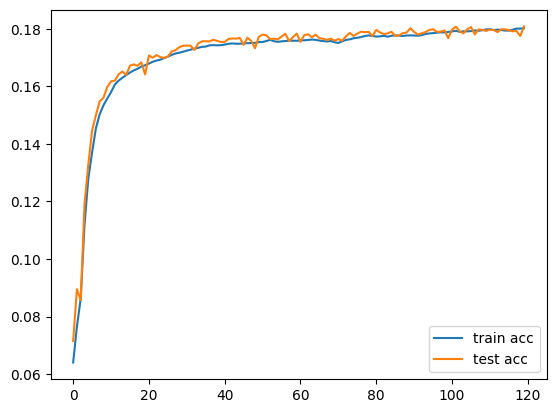

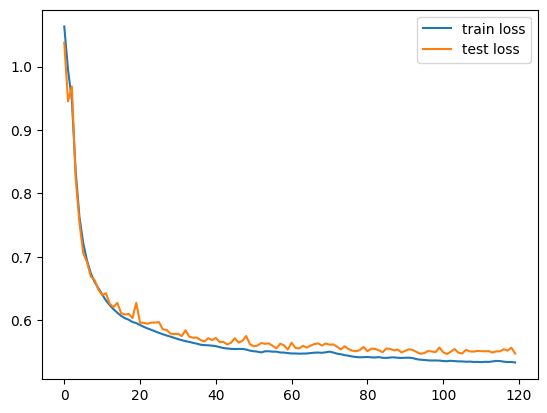

In [24]:
import matplotlib.pyplot as plt

plt.plot(history.history['acc'], label='train acc')
plt.plot(history.history['val_acc'], label='test acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='test loss')
plt.legend()
plt.show()

## Assemble the model for sequence generation

In [25]:
encoder_model = Model(encoder_inputs, encoder_states)
thought_input = [Input(shape=(num_neurons,)), Input(shape=(num_neurons,))]

decoder_outputs, state_h, state_c = decoder_lstm(decoder_inputs,
                                initial_state=thought_input)
decoder_states = [state_h, state_c]
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(inputs=[decoder_inputs] + thought_input,
                      outputs=[decoder_outputs] + decoder_states)

## Save the models

In [26]:
with open("../src/part_9/chatbot_model/encoder_model.json", 'w') as json_file:
    json_file.write(encoder_model.to_json())

encoder_model.save_weights('../src/part_9/chatbot_model/encoder_model.h5')


with open("../src/part_9/chatbot_model/decoder_model.json", 'w') as json_file:
    json_file.write(decoder_model.to_json())

decoder_model.save_weights('../src/part_9/chatbot_model/decoder_model.h5')

In [27]:
print(reverse_target_char_index)

{0: '\t', 1: '\n', 2: ' ', 3: '!', 4: "'", 5: ',', 6: '.', 7: '0', 8: '1', 9: '2', 10: '3', 11: '4', 12: '5', 13: '6', 14: '7', 15: '8', 16: '9', 17: ':', 18: ';', 19: '?', 20: 'a', 21: 'b', 22: 'c', 23: 'd', 24: 'e', 25: 'f', 26: 'g', 27: 'h', 28: 'i', 29: 'j', 30: 'k', 31: 'l', 32: 'm', 33: 'n', 34: 'o', 35: 'p', 36: 'q', 37: 'r', 38: 's', 39: 't', 40: 'u', 41: 'v', 42: 'w', 43: 'x', 44: 'y', 45: 'z'}


In [28]:
print(input_token_index)

{' ': 0, '!': 1, "'": 2, ',': 3, '.': 4, '0': 5, '1': 6, '2': 7, '3': 8, '4': 9, '5': 10, '6': 11, '7': 12, '8': 13, '9': 14, ':': 15, ';': 16, '?': 17, 'a': 18, 'b': 19, 'c': 20, 'd': 21, 'e': 22, 'f': 23, 'g': 24, 'h': 25, 'i': 26, 'j': 27, 'k': 28, 'l': 29, 'm': 30, 'n': 31, 'o': 32, 'p': 33, 'q': 34, 'r': 35, 's': 36, 't': 37, 'u': 38, 'v': 39, 'w': 40, 'x': 41, 'y': 42, 'z': 43}


In [29]:
print(max_encoder_seq_length)

100


In [30]:
print(max_decoder_seq_length)

102


## Build a char-based translator

In [31]:
def decode_sequence(input_seq):
    thought = encoder_model.predict(input_seq)

    target_seq = np.zeros((1, 1, output_vocab_size))
    target_seq[0, 0, target_token_index[stop_token]] = 1.
    stop_condition = False
    generated_sequence = ''

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + thought)

        generated_toked_idx = np.argmax(output_tokens[0, -1, :])
        generated_char = reverse_target_char_index[generated_toked_idx]
        generated_sequence += generated_char
        if (generated_char == stop_token) \
                or (len(generated_sequence) > max_decoder_seq_length):
            stop_condition = True

        target_seq = np.zeros((1, 1, output_vocab_size))
        target_seq[0, 0, generated_toked_idx] = 1.
        thought = [h, c]

    return generated_sequence

## Generate a response

In [32]:
def response(input_sentence):
    input_seq = np.zeros((1, max_encoder_seq_length, input_vocab_size),
                         dtype='float32')
    for t, char in enumerate(input_sentence):
        input_seq[0, t, input_token_index[char]] = 1.
    decoded_sentence = decode_sequence(input_seq)
    print('Bot Reply (Decoded sentence):', decoded_sentence)

In [33]:
response("what is the internet?")

1/1 [==============================] - 0s 21ms/step
Bot Reply (Decoded sentence): it's the world.



In [34]:
response("why?")

1/1 [==============================] - 0s 23ms/step
Bot Reply (Decoded sentence): if there are you to take the trouse.



In [35]:
response("do you like coffee?")

1/1 [==============================] - 0s 24ms/step
Bot Reply (Decoded sentence): if really.



In [36]:
response("do you like football?")

1/1 [==============================] - 0s 25ms/step
Bot Reply (Decoded sentence): if really.



In [39]:
response('do you know, who am i')

1/1 [==============================] - 0s 20ms/step
Bot Reply (Decoded sentence): if what the hell is the traked.



In [40]:
response('what do you know about rb night chaos?')

1/1 [==============================] - 0s 24ms/step
Bot Reply (Decoded sentence): if what is it.



In [41]:
response('say hello')

1/1 [==============================] - 0s 24ms/step
Bot Reply (Decoded sentence): if there are you.



In [42]:
response('hi, bot!')

1/1 [==============================] - 0s 20ms/step
Bot Reply (Decoded sentence): it'me worried.



In [43]:
response('so what are you doing?')

1/1 [==============================] - 0s 25ms/step
Bot Reply (Decoded sentence): if there.



In [44]:
response('what are you doing?')

1/1 [==============================] - 0s 37ms/step
Bot Reply (Decoded sentence): it's and the start.



In [45]:
response('show your dick')

1/1 [==============================] - 0s 23ms/step
Bot Reply (Decoded sentence): if why we're torred.



In [46]:
response('say something funny')

1/1 [==============================] - 0s 18ms/step
Bot Reply (Decoded sentence): if what do you mean.



In [47]:
response('random code to you dear')

1/1 [==============================] - 0s 24ms/step
Bot Reply (Decoded sentence): if there.



In [48]:
response('something new')

1/1 [==============================] - 0s 19ms/step
Bot Reply (Decoded sentence): if there.



In [50]:
response('something else')

1/1 [==============================] - 0s 25ms/step
Bot Reply (Decoded sentence): if there.

